In [1]:
print("Python běží!")

Python běží!


In [2]:
import sys

sys.path.append('../')
sys.path.append('../my_libs/')
sys.path.append('../my_libs/img/')

!{sys.executable} -m pip install -r ../../pip-dependencies.txt

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import my_libs as ml
from my_libs.tools import *
from my_libs.fft import *
from my_libs.colors import *
from my_libs.img.processing import *

In [4]:
ml.tools.printf("Hello world!")

Hello world!

# Cvičení 8: slunečnice

Vytvořte  základní detektor  slunečnicových  květů  pomocí operace Laplacián  Gaussiánu  a  vyhodnoťte  jeho  úspěšnost  metrikami  precision  a recall. 

### Postup:
- Detekujte  tmavé  bloby  na  světlém  pozadí  pomocí  operace  **Laplacián Gaussiánu**. 
- Okolo  každého  blobu  vyřízněte  čtvercovou  oblast  o straně  přibližně `4*sigma.` 
- Oblast  převeďte  do  barevného  prostoru  HSV/HSL/...  a  ze  složky  hue vypočtěte histogram. 
- Porovnejte  histogram  se  shodně  připraveným  histogramem  vzorového obrázku `pvi_cv08_sunflower_template.jpg` pomocí Kullback-Lieblerovy divergence.  Pokud se ve vypočtených divergencích objeví  NaN,  přičtěte do porovnávaných histogramů malé číslo, např. 0.001,  aby  nedocházelo k logaritmování nebo dělení nulou. 
- Vhodně  stanoveným  prahem  divergence filtrujte oblasti, které nejsou slunečnicové květy. 
- Opakujte postup pro obrázky se slunečnicemi v archivu pvi_cv08.zip 
- Podobně  jako  ve  cvičení  č.  7  vypočtěte  hodnoty  **precision**  a  **recall**  při IoU=0.5. 
 
### Zdroje:
- https://scikit-image.org/docs/stable/api/skimage.feature.html 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html 

In [5]:
folder = 'data/'
IoU=0.5
#a = 4*sigma
sunflower_template_file = "pvi_cv08_sunflower_template.jpg"

In [6]:
from my_libs.img import images
# reload img module
import importlib
importlib.reload(images)

# Find files
files = images.find(folder, "txt")  
files.sort()

# Filter images
picture_files = images.find(folder, "jpg")
picture_files.sort()

# remove template file
for i in range(len(picture_files)):
    if picture_files[i].find(sunflower_template_file) != -1:
        picture_files.pop(i)
        break

number_of_images = len(picture_files)
print("Number of images: ", number_of_images)


# Load images
imgs = images.load(picture_files)

Current working directory: /home/pytel/Skola/TUL-navazující_studium/3. semestr/PVI-Pocitacove_videni/cviceni/cv08, files: 
pvi_cv08_sunflowers4.txt
pvi_cv08_sunflowers1.txt
pvi_cv08_sunflowers2.txt
pvi_cv08_sunflowers3.txt
Current working directory: /home/pytel/Skola/TUL-navazující_studium/3. semestr/PVI-Pocitacove_videni/cviceni/cv08, files: 
pvi_cv08_sunflowers2.jpg
pvi_cv08_sunflowers3.jpg
pvi_cv08_sunflowers4.jpg
pvi_cv08_sunflower_template.jpg
pvi_cv08_sunflowers1.jpg
Number of images:  4


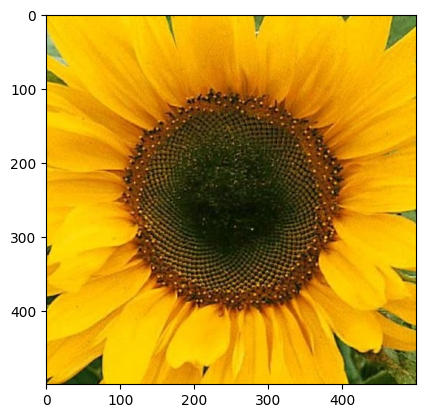

In [7]:
# Load template
img_template_bgr = cv2.imread(folder + sunflower_template_file)
img_template = cv2.cvtColor(img_template_bgr, cv2.COLOR_BGR2RGB)


# visualize template
plt.imshow(img_template)

Text(0.5, 1.0, 'Histogram H')

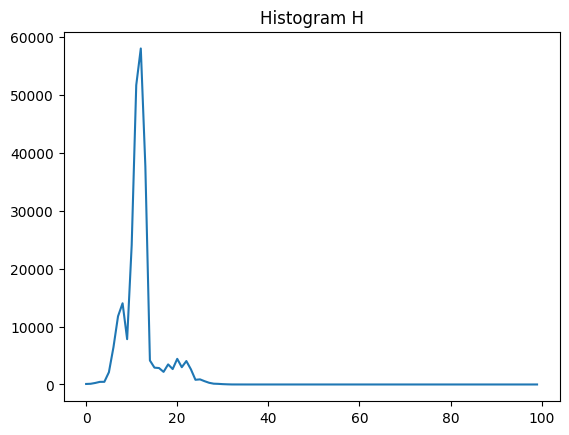

In [ ]:
# prevod do HSV
img_template_hsv = cv2.cvtColor(img_template, cv2.COLOR_RGB2HSV)
H, S, V = cv2.split(img_template_hsv)

# vypocet histogramu
HIST_LEN = 100
img_template_hist_H = cv2.calcHist([H], [0], None, [HIST_LEN], [0, 180])

# vizualizace
plt.figure()
plt.plot(img_template_hist_H)
plt.title("Histogram H")

#print(hist_H)

(424, 640, 3)


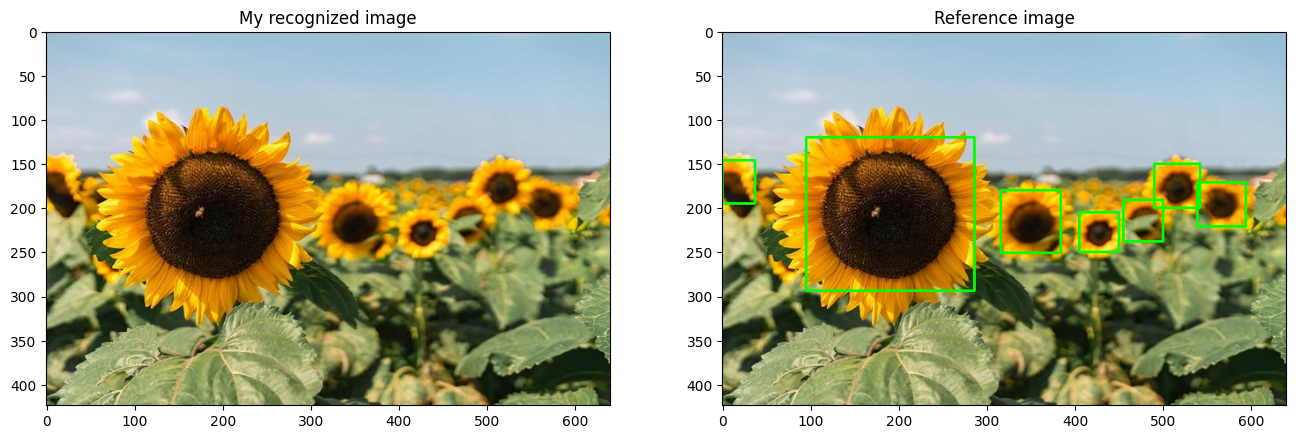

In [18]:
recognition_color = (255, 0, 0)
reference_color = (0, 255, 0)
thickness = 2

# load first file and visualize
for image, text_file in zip(imgs, files):
    referece_img = image.copy()
    # read file
    for box_coord in dict_files_boxes[text_file]:
        x1, y1 = box_coord[0]
        x2, y2 = box_coord[1]
        cv2.rectangle(referece_img, (x1, y1), (x2, y2), reference_color, thickness)
    
    print(image.shape)
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("My recognized image")
    plt.subplot(1, 2, 2)
    plt.imshow(referece_img)
    plt.title("Reference image")
    break

## Vykreslení na všech obrázcích

In [15]:
def file_to_xy_box(file_path):
    """ 

    Returns:
        list of tuples ((x1, y1), (x2, y2))
    """
    NUMBER_OF_VALUES = 4
    def parse_line_to_ints(line):
        values = line.split()
        return [int(value) for value in values]

    def is_text_file(file_path):
        return file_path.endswith('.txt')
    
    if not is_text_file(file_path):
        raise ValueError("File is not text file")
    
    lines = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        numbers =  parse_line_to_ints(line)
        if len(numbers) != NUMBER_OF_VALUES:
            raise ValueError("Line has not 4 numbers")
        yield ((numbers[0], numbers[1]), (numbers[2], numbers[3]))
        

def load_files_to_dict(files):
    dict_files_boxes = {}
    for file in files:
        dict_files_boxes[file] = list(file_to_xy_box(file))
    return dict_files_boxes

# nacteni textovych souboru
dict_files_boxes = load_files_to_dict(files)

((95, 120), (286, 294))
((316, 180), (384, 251))
((405, 205), (450, 250))
((455, 191), (500, 238))
((490, 150), (542, 200))
((539, 171), (594, 221))
((0, 146), (37, 195))
(424, 640, 3)


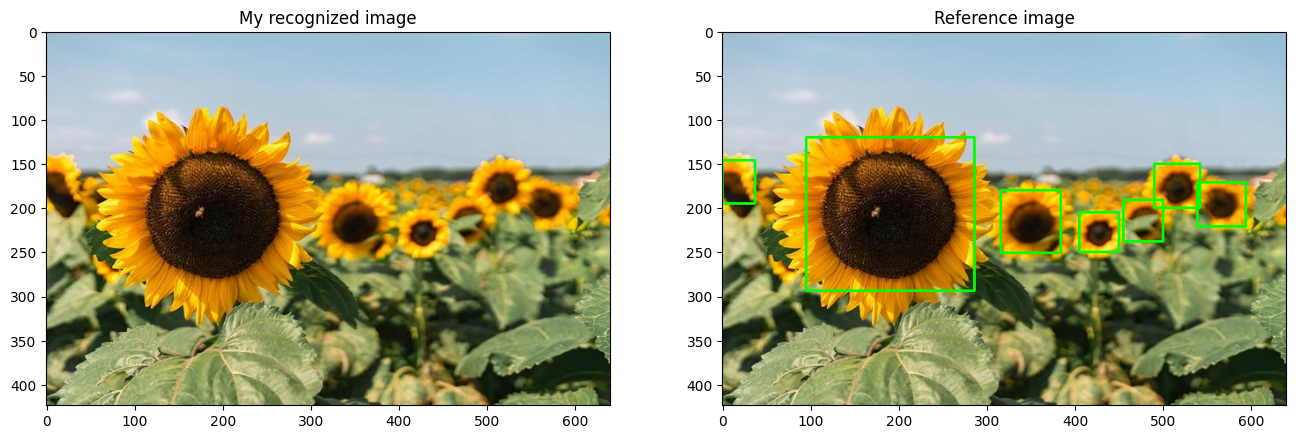

In [ ]:
recognition_color = (255, 0, 0)
reference_color = (0, 255, 0)
thickness = 2

# load first file and visualize
for image, text_file in zip(imgs, files):
    referece_img = image.copy()
    # read file
    for box_coord in dict_files_boxes[text_file]:
        print(box_coord)
        x1, y1 = box_coord[0]
        x2, y2 = box_coord[1]
        cv2.rectangle(referece_img, (x1, y1), (x2, y2), reference_color, thickness)
    
    print(image.shape)
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("My recognized image")
    plt.subplot(1, 2, 2)
    plt.imshow(referece_img)
    plt.title("Reference image")
    break